In [2]:
''' MAIN 
Load model for inspection'''

import os
import matplotlib.pyplot as plt
import numpy as np
from keras import Model
from astropy.io import fits
from astropy.table import Table

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from DESOM_streamlined import DESOM

X=np.zeros((3,4544)) #shape used for loading model

#----------------------------- Model Path -----------------------------------
MODEL='oct13_x'
model_path = 'results/tmp/'+MODEL+'/DESOM_model_final.h5'

#------------------------------------------ Load the DESOM model -------------------------------
def load_desom_trained(map_size, input_dims, model_path, latent):
    som = DESOM(input_dims= input_dims, map_size = map_size, latent=latent)
    som.initialize()
    som.load_weights(model_path)
    return som

map_size = (15,15)
som = load_desom_trained(map_size, X.shape[1], model_path, latent=256)


Using TensorFlow backend.


In [25]:
''' MAIN
Load spectra
Map a subset (Xmin) to the Self-Organizing Map of the loaded model.
Also loads attributes (Ymin) and save location of where the spectrum lands 
''' 

#----------- LOAD SPECTRA and ADD SOME PARAMETERS---------
SUBSET=40_000
SUBSET=min(SUBSET,X.shape[0])

X=np.load('X_test250k.npy')
Xmin=X[:SUBSET,:]
Y_test=Table.read('Y_test250k.fits')
Ymin=Y_test[:SUBSET]

# Take log of ML_r
Ymin['logML_r']=np.log(Ymin['ML_r'])

# Fix MS_dens, add sSFR
from astropy.cosmology import FlatLambdaCDM
cosmod = FlatLambdaCDM(name='Concordance',H0=70.0,Om0=0.3,Tcmb0=2.725, Neff=3.04, Ob0=0.0463)
pixscale = 0.000138889*3600. # arcsec (seems to be same for all cubes)
pixscale = pixscale/3600.*np.pi/180. # radians
comd_bax = cosmod.comoving_distance(Ymin['redshift']).value*1.0e3 #comoving dist in kpc
spaxsize_bax = pixscale*comd_bax/(1.0 + Ymin['redshift']) # kpc
spaxsize_bax = spaxsize_bax**2. # kpc^2
Ymin['logMS_dens_kpc'] = Ymin['logMs_dens'] - np.log10(spaxsize_bax)  # solar mass per kpc^2
Ymin['sSFR']=Ymin['logSFR_dens']-Ymin['logMS_dens_kpc']

# ---------- Bin each spectrum into the best node and save location-------------
Ymin['bmu']=som.predict(Xmin)


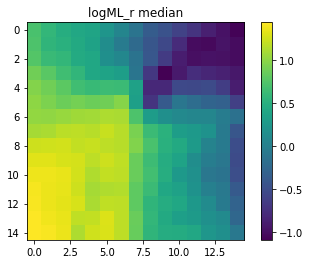

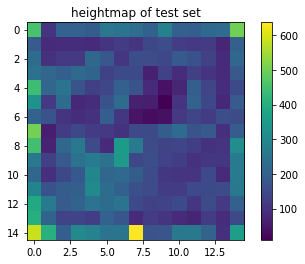

In [28]:
''' INSPECT
Colour DESOM-1 map by an attribute.
Create a map showing distribution of spectra into node ("heightmap")'''

ATTR='logML_r' #for other attributes, run 'print(Ymin.colnames)'
# --------- 

attr_av=np.zeros(map_size[0]*map_size[1])
heightmap=np.zeros(map_size[0]*map_size[1])

for bmu in range(map_size[0]*map_size[1]):
    masked=(Ymin['bmu']==int(bmu))
    temp_list=Ymin[ATTR][masked]
    attr_av[bmu]=np.nanmedian(temp_list)
    heightmap[bmu]=len(Ymin[masked])
    
# ------- Plot Average Values ------
plt.figure(0)
plt.imshow(attr_av.reshape(map_size))
plt.title(ATTR+' median')
plt.colorbar()

# ------- Plot Distribution of Spectra in nNodes ------
plt.figure(1)
plt.imshow(heightmap.reshape(map_size))
plt.title('heightmap of test set')
plt.colorbar()



node: 24
median is: -0.5431466697984767
number of specra: 158
node: 34
median is: 0.41321950708636157
number of specra: 221


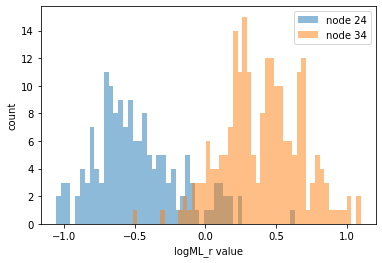

In [57]:
''' INSPECT
look at the distribution of values within a node'''

def inspect_node(ATTR,node,bins=50):
    masked=(Ymin['bmu']==int(node))
    plt.hist(Ymin[ATTR][masked],bins=bins,alpha=0.5,label='node '+str(node))
    print('node:',node)
    print('median is:',np.median(Ymin[ATTR][masked]))
    print('number of specra:',len(Ymin[ATTR][masked]))
    
ATTR='logML_r'
inspect_node(ATTR,24)
inspect_node(ATTR,34)
plt.ylabel('count')
plt.xlabel(str(ATTR)+' value')
plt.legend()

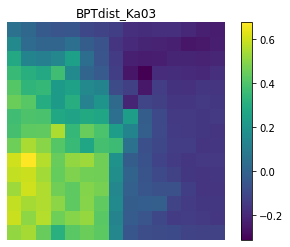

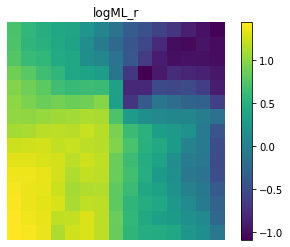

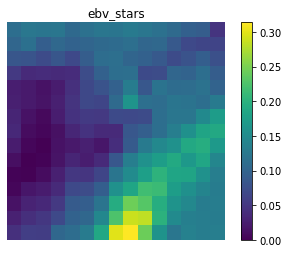

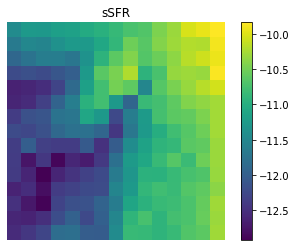

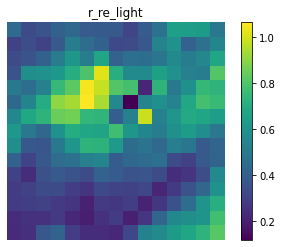

In [36]:
''' INSPECT
Look at multiple attributes (in separate figures)
'''

ATTR=['BPTdist_Ka03','logML_r','ebv_stars','sSFR','r_re_light']

for m in range(len(ATTR)):
    plt.figure(m)
    attr_av=np.zeros(map_size[0]*map_size[1])
    for bmu in range(map_size[0]*map_size[1]):
        masked=(Ymin['bmu']==int(bmu))
        temp_list=Ymin[ATTR[m]][masked]
        attr_av[bmu]=np.nanmedian(temp_list)
    plt.imshow(attr_av.reshape(map_size))
    plt.title(ATTR[m])
    plt.axis('off')
    plt.colorbar()


Text(0.5, 1.0, 'AE reconstruction error')

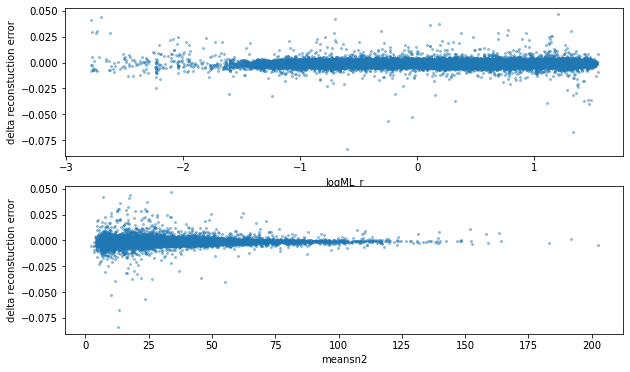

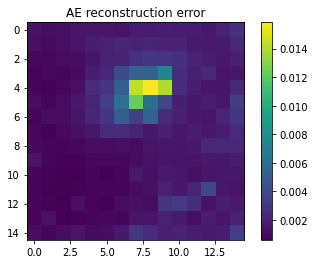

In [37]:
''' INSPECT
Look at reconstruction error, and where the model has issues
'''

# ---------- Calculate Autoencoder Reconstruction error -------
recons=som.autoencoder.predict(Xmin)
delta=recons-Xmin

# --------- Spread out by a couple variables -----------
ATTR='logML_r'
fig,ax=plt.subplots(2,1,figsize=(10,6))
ax[0].scatter(Ymin[ATTR],np.average(delta,axis=1),s=4,alpha=0.4)
ax[0].set_xlabel(ATTR)
ax[0].set_ylabel('delta reconstuction error')

ATTR='meansn2'
ax[1].scatter(Ymin[ATTR],np.average(delta,axis=1),s=4,alpha=0.4)
ax[1].set_xlabel(ATTR)
ax[1].set_ylabel('delta reconstuction error')

# ---------- Reshape to SOM (map to bmu, then take std_dev -----------
temp_error=np.zeros(225)
for i in range(225):
    mask=(Ymin['bmu']==i)
    temp=delta[mask].mean(axis=1)
    temp_error[i]=temp.std()

plt.figure(2)
plt.imshow(temp_error.reshape(15,15))
plt.colorbar()
plt.title('AE reconstruction error')

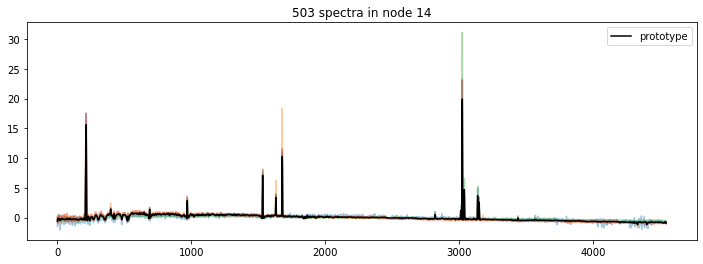

In [64]:
''' INSPECT
Visualize a selection of spectra from a node compared to the prototype'''

# --------- DEFINE PARAMETERS ---------
node_index=14
mask=(Ymin['bmu']==int(node_index))

MAX_SAMPLES=4
decoded_prototypes = som.decode(som.prototypes)

# ---------- PLOT -------
plt.figure(0,figsize=(12,4))

for i in range(min(sum(mask),MAX_SAMPLES)):
    plt.plot(Xmin[mask][i],alpha=0.4)
plt.plot(decoded_prototypes[node_index],c='black',label='prototype')

plt.title(str(sum(mask))+' spectra in node '+str(node_index))
plt.legend()


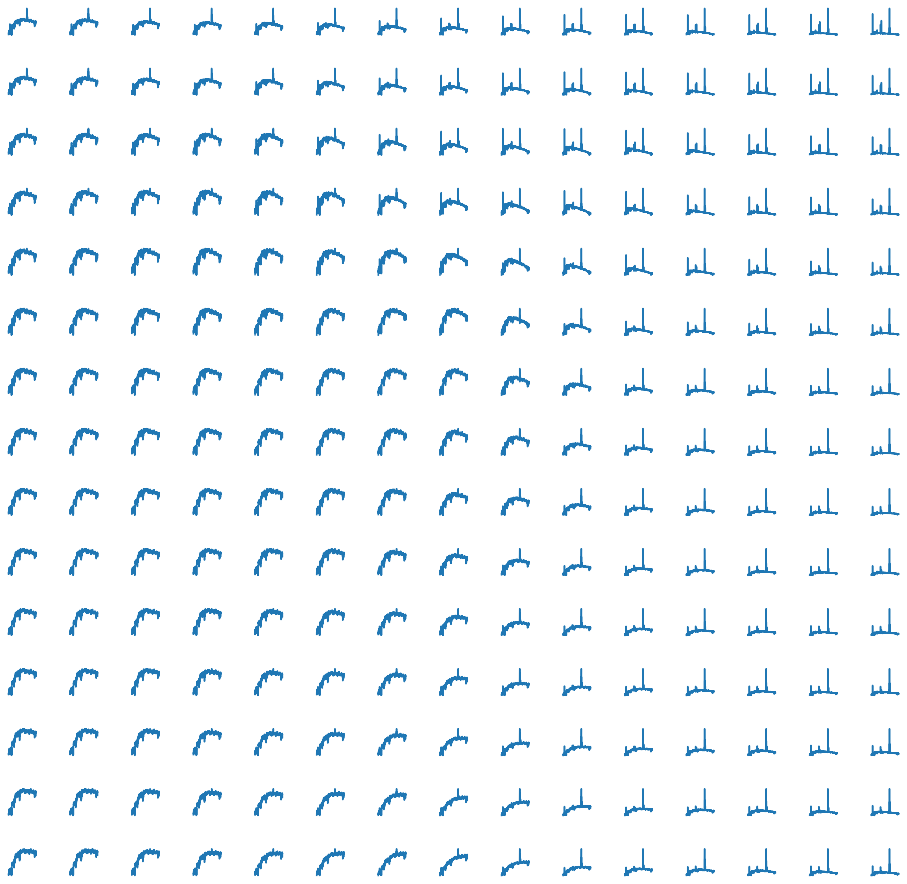

In [4]:
'''INSPECT
Plot the decoded prototype for each node'''

decoded_prototypes = som.decode(som.prototypes)
fig, ax = plt.subplots(map_size[0], map_size[1], figsize=(16,16))
for k in range(map_size[0] * map_size[1]):
    x = decoded_prototypes[k]
    ax[k // map_size[1]][k % map_size[1]].plot(x)
    ax[k // map_size[1]][k % map_size[1]].axis('off')
plt.subplots_adjust(hspace=1.05, wspace=1.05)


(-0.5, 255.5, 1.5, -0.5)

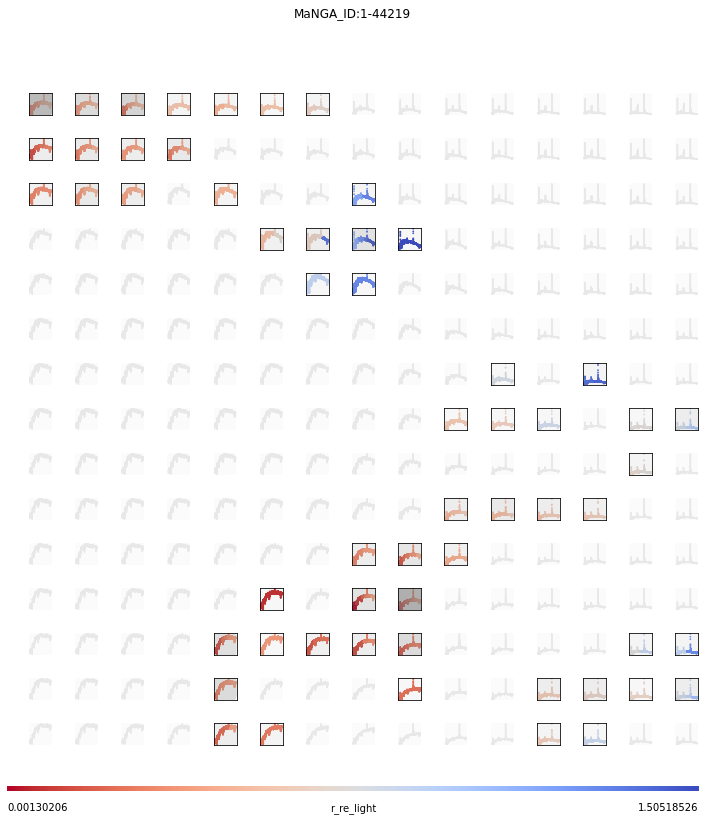

In [65]:
''' INSPECT
Dotwise colouring to capture different values within a prototype '''
import matplotlib as mpl
import matplotlib.cm as cm

data_path='data/gal_split_100/' # separated galaxy data.
MaNGA_SUFFIX=44219

ATTR='r_re_light'
#ATTR='logMS_dens_kpc'
decoded_prototypes = som.decode(som.prototypes)

# ------------------------ LOAD DATA and ADD ATTRIBUTES--------------------
test_gal=np.load(data_path+str(MaNGA_SUFFIX)+'.npy')    #load spectra
test_gal=StandardScaler().fit_transform(test_gal.T).T   #normalize spectra
#
Y_info=Table.read(data_path+str(MaNGA_SUFFIX)+'_info.fits') #load data

# Note: These have to be recalculated because this is for a specific galaxy.
#       The above calculation was for the test set.
Y_info['bmu']=som.predict(test_gal)
Y_info['logML_r']=np.log(Y_info['ML_r'])

from astropy.cosmology import FlatLambdaCDM
cosmod = FlatLambdaCDM(name='Concordance',H0=70.0,Om0=0.3,Tcmb0=2.725, Neff=3.04, Ob0=0.0463)
pixscale = 0.000138889*3600. # arcsec (seems to be same for all cubes)
pixscale = pixscale/3600.*np.pi/180. # radians
comd_bax = cosmod.comoving_distance(Y_info['redshift']).value*1.0e3 #comoving dist in kpc
spaxsize_bax = pixscale*comd_bax/(1.0 + Y_info['redshift']) # kpc
spaxsize_bax = spaxsize_bax**2. # kpc^2
Y_info['logMS_dens_kpc'] = Y_info['logMs_dens'] - np.log10(spaxsize_bax)  # solar mass per kpc^2
Y_info['sSFR']=Y_info['logSFR_dens']-Y_info['logMS_dens_kpc']
#-----------------------------------------------------    

heightmap=np.zeros(map_size[0]*map_size[1])

# ------------- PREP COLOURS -------
finite_mask=(np.isfinite(Y_info[ATTR]))
vmin=Y_info[ATTR][finite_mask].min()
vmax=Y_info[ATTR][finite_mask].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.coolwarm_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

# --------- SAMPLE FROM COLOURSPACE -------
colours=np.zeros((map_size[0]*map_size[1],test_gal.shape[1],4))
for bmu in range(map_size[0]*map_size[1]): #loop bmu
    masked=(Y_info['bmu']==int(bmu))
    temp_list=Y_info[ATTR][masked]
    temp_list.sort()
    for i in range(len(temp_list)): #sample for each spectra
        temp_spacing=int(4544/(len(temp_list)))
        colours[bmu,temp_spacing*i:temp_spacing*i+temp_spacing]=m.to_rgba(temp_list[i])
    heightmap[bmu]=len(Y_info[masked])

# -------- Heightmap Normalized for background colouring -------
scaled_alpha=MinMaxScaler().fit_transform(heightmap.reshape(-1,1)).flatten()
scaled_alpha=scaled_alpha*0.6

# ------- START PLOTTING -------
fig, ax = plt.subplots(map_size[0], map_size[1], figsize=(12,12))
fig.suptitle(str('MaNGA_ID:'+ Y_info['mangaID'][0]))

# ------- FOR EACH BMU -------
for k in range(map_size[0]*map_size[1]):
    x = decoded_prototypes[k] # select prototype
    if sum(colours[k,0,:])!=0.: # if there are spectra here:
        # ... create scatter for activated nodes, coloured by sorted values:
        ax[k // map_size[0]][k % map_size[1]].scatter(range(4544),x,c=colours[k,:,:],cmap=cmap,s=0.5)
        ax[k // map_size[0]][k % map_size[1]].set_xticks([])
        ax[k // map_size[0]][k % map_size[1]].set_yticks([])
    else:
        # ... create grey ('ghosted') prototype:
        ax[k // map_size[0]][k % map_size[1]].plot(x,c='grey',alpha=0.15)
        ax[k // map_size[0]][k % map_size[1]].axis('off')
    # colour background by number of spectra:
    background = (decoded_prototypes[k].max()-decoded_prototypes[k].min())*np.random.random_sample(4544)+decoded_prototypes[k].min()
    ax[k // map_size[0]][k % map_size[1]].plot(background,alpha=scaled_alpha[k],c='grey') #background for activated
    ax[k // map_size[0]][k % map_size[1]].plot(background,alpha=0.015,c='black') #floor value of backgrounds
plt.subplots_adjust(hspace=1.01, wspace=1.01)


# ----- COLOUR BAR ------
gradient=(np.linspace(vmin,vmax,256))
gradient = np.vstack((gradient, gradient))

# left,bottom,weight,height
caxleft=plt.axes([0.1,0.05,0,0])
caxleft.text(0,0,str(round(vmin,8)))
caxleft.axis('off')
#
caxright=plt.axes([0.9,0.05,0,0])
caxright.text(0,0,str(round(vmax,8)),horizontalalignment='right')
caxright.axis('off')
#
caxcent=plt.axes([0.5,0.05,0,0])
caxcent.text(0,0,str(ATTR),horizontalalignment='center')
caxcent.axis('off')    
#
cax1=plt.axes([0.1,0.05,0.8,0.05])
cax1.imshow(gradient, cmap=cmap)
cax1.axis('off')
            